In [27]:
import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import plotly.io as pio

import pandas as pd
import os 
from pathlib import Path
from nltk.corpus import stopwords

from preprocessing.preprocessing_module import full_cleaning_pipeline


METAPROJECT_NAME = 'TopicModelling_META'
SUBPROJECT_NAME = 'TopMod_pipeline'



DATASET_NAME = "SensoryTool_CombinedData.csv"
HIGH_SENSORY = True #If False, corresponds to deep listening experience (no flicker)
CONDITION = 'highsensory' if HIGH_SENSORY else 'deeplistening'
print(f'Condition : "{CONDITION}"')




PROJDIR = os.path.expanduser(f"~/projects/{METAPROJECT_NAME}")
DATADIR = os.path.join(PROJDIR,f'DATA/{DATASET_NAME}')
CODEDIR = os.path.join(PROJDIR,f'{SUBPROJECT_NAME}')



%matplotlib inline

Condition : "highsensory"


Parameters for BERTopic

https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html

In [28]:
from transformers.pipelines import pipeline

#Parameters for Topic Modelling
remove_stopwords = True

embedding_model = "bert-base-cased"#"all-MiniLM-L6-v2" #which transformer-based model to use to create embeddings of the reports
# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# topic_model = BERTopic(embedding_model=embedding_model)
min_topic_size = 5 #sets the minimum number of reports that a topic should have
min_topic_size_range = range(15, 1, -1)  # Adjust the range as per your requirement

Import Data

In [29]:
# Raw text data
dataset = pd.read_csv(DATADIR)[['reflection_answer', 'meta_HighSensory']]
# Filter based on HIGH_SENSORY flag
filtered_dataset = dataset[(dataset['meta_HighSensory'] == HIGH_SENSORY) & 
                           dataset['reflection_answer'].notna() & 
                           (dataset['reflection_answer'] != '')]

filtered_dataset

/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_11350/2716229648.py:2: DtypeWarning:

Columns (23,24,71,73,75,77,109,111,112,113,114,115,116,117,118,119,120,121,122,123,124,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,157,159,161,165,168,196,203,205) have mixed types. Specify dtype option on import or set low_memory=False.



,reflection_answer,meta_HighSensory
83,Intense chaos. And then my mind checked out an...,True
99,good stuff.\n,True
120,a pattern of red and white lights thatflashed ...,True
172,i wentback to many hard and mostly beautiful m...,True
189,Hello,True
...,...,...
15726,Changing temperature of my body with the light...,True
15736,pleasure & intrigue,True
15761,travelling through space\n,True
15778,i thought alot about rands journey into rhudia...,True


In [30]:
#Preprocessed text data
#check if preprocessed dataset already exist, and if not, create a preprocessed dataset and store it in the preprocessing folder

base_name, ext = os.path.splitext(DATASET_NAME)
new_path = f"{base_name}_{CONDITION}_preprocessed_stopwords{ext}" if remove_stopwords else f"{base_name}_{CONDITION}_preprocessed{ext}"
preproc_path = os.path.join(PROJDIR, f'DATA/preprocessed/{new_path}')


# Check if the preprocessed file already exists
if not os.path.exists(preproc_path):
    # If not, create it using the full_cleaning_pipeline function and save it
    reports = full_cleaning_pipeline(filtered_dataset, 'reflection_answer',text_clean_flag=remove_stopwords)
    reports = reports.reset_index(drop=True)
    
    # Ensure the directory exists before saving the file
    os.makedirs(os.path.dirname(preproc_path), exist_ok=True)
    
    reports.to_csv(preproc_path, index=False)
else:
    reports = pd.read_csv(preproc_path)
    print(f"The preprocessed file already exists at: {preproc_path}")

data = reports['reflection_answer']

print('N={} reports (HighSensory = {})'.format(len(reports),HIGH_SENSORY))
reports.head()

The preprocessed file already exists at: /Users/rb666/projects/TopicModelling_META/DATA/preprocessed/SensoryTool_CombinedData_highsensory_preprocessed_stopwords.csv
N=307 reports (HighSensory = True)


,reflection_answer,meta_HighSensory
0,Intense chaos And mind checked unconscious too...,True
1,pattern red white lights thatflashed andbecame...,True
2,wentback many hard mostly beautiful memories w...,True
3,Hope colour,True
4,dreaming awake flashes random places maybe lik...,True


## BERTopic

https://miro.medium.com/v2/resize:fit:4800/format:webp/0*DxAqCqx6dzg0KQlg.png

In [31]:
# finds the maximum min_topic_size that doesn't cause an error

def find_max_topics(data, embedding_model, min_topic_size_range):
    """ 
    Returns the maximum number of topics and the optimal minimum topic size found :
    - max_topics: Keeps track of the maximum number of topics found during the iterations.
    - optimal_min_topic_size: Stores the min_topic_size value that resulted in max_topics.
    """
    max_topics = 0
    optimal_min_topic_size = 0
    
    for min_size in min_topic_size_range:
        try:
            model = BERTopic(language="english", 
                             calculate_probabilities=True, 
                             verbose=True,
                             nr_topics='auto', # Automatically determines the number of topics.
                             embedding_model=embedding_model,
                             min_topic_size=min_size)
            
            topics, _ = model.fit_transform(data)
            num_topics = len(set(topics))  # Calculate the number of unique topics
            
            if num_topics > max_topics:
                max_topics = num_topics
                optimal_min_topic_size = min_size
                
            print(f"Min_topic_size: {min_size}, Num Topics: {num_topics}")
            
        except ValueError as e:
            print(f"Error with min_topic_size: {min_size}. Error message: {str(e)}")
            continue
        
    return max_topics, optimal_min_topic_size

if not min_topic_size:
    max_topics, optimal_min_topic_size = find_max_topics(data, embedding_model, min_topic_size_range)
    print(f"Maximum number of topics: {max_topics} found with min_topic_size: {optimal_min_topic_size}")
else:
    optimal_min_topic_size = min_topic_size


print(f"Setting min_topic_size = {optimal_min_topic_size}")


Setting min_topic_size = 5


### Training the BERT model

In [32]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True,nr_topics='auto',embedding_model=embedding_model,min_topic_size=optimal_min_topic_size) #The higher the value of min_topic_size, the more specific the topics will be
topics, probs = model.fit_transform(reports['reflection_answer']) #Fit model to data : topics are the topic labels for each document, probs are the probabilities of each topic for each document
model.visualize_topics() #Visualize topics


No sentence-transformers model found with name /Users/rb666/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/rb666/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-20 09:58:48,542 - BERTopic - Transformed documents to Embeddings
2023-11-20 09:58:49,675 - BERTopic - Reduced dimensionality
2023-11-20 09:58:49,685 - BERTopic - Clustered reduced embeddings
2023-11-20 09:58:49,705 - BERTopic - Reduced number of topics from 8 to 8


### Topic extraction and representation

In [33]:
freq = model.get_topic_info(); freq.head(5) #look at the most frequent topics first as they best represent the collection of documents

,Topic,Count,Name,Representation,Representative_Docs
0,-1,61,-1_experience_like_intense_orange,"[experience, like, intense, orange, something,...",[That surprised time th experience high sensor...
1,0,91,0_felt_like_saw_experience,"[felt, like, saw, experience, feel, it, deep, ...",[Mainly stressed moments calm went dark blue s...
2,1,78,1_saw_shapes_moving_patterns,"[saw, shapes, moving, patterns, geometric, kal...",[Colour fields varying colours changed rapidly...
3,2,31,2_peace_calm_happiness_hope,"[peace, calm, happiness, hope, sense, relaxati...","[great sense calm belonging, amazing sense pea..."
4,3,22,3_far_wish_stopped_try,"[far, wish, stopped, try, would, relaxing, eve...",[awesome experience much expected Diolch far L...


In [34]:
model.get_topic(0)  # Select the most frequent topic

[('felt', 0.06101319137431669),
 ('like', 0.0526974826133362),
 ('saw', 0.03725169510578425),
 ('experience', 0.035766356095847884),
 ('feel', 0.02295637446512239),
 ('it', 0.022173860325551003),
 ('deep', 0.020563980829991217),
 ('sense', 0.019265638525171852),
 ('blue', 0.018699288304045814),
 ('space', 0.01847821693795917)]

In [35]:
# Visualise topic distributions to understand how confident BERTopic is that certain topics can be found in a document
model.visualize_distribution(probs[200], min_probability=0.015)

In [36]:
model.visualize_hierarchy(top_n_topics=15)

In [37]:
topic_freq = model.get_topic_freq().head() #Get the frequency of each topic
freq = model.get_topic_info() #see the most representative terms for each topic
print("N number of topics: ",len(freq))
print(freq.head())


N number of topics:  8
   Topic  Count                               Name  \
0     -1     61  -1_experience_like_intense_orange   
1      0     91         0_felt_like_saw_experience   
2      1     78       1_saw_shapes_moving_patterns   
3      2     31        2_peace_calm_happiness_hope   
4      3     22             3_far_wish_stopped_try   

                                      Representation  \
0  [experience, like, intense, orange, something,...   
1  [felt, like, saw, experience, feel, it, deep, ...   
2  [saw, shapes, moving, patterns, geometric, kal...   
3  [peace, calm, happiness, hope, sense, relaxati...   
4  [far, wish, stopped, try, would, relaxing, eve...   

                                 Representative_Docs  
0  [That surprised time th experience high sensor...  
1  [Mainly stressed moments calm went dark blue s...  
2  [Colour fields varying colours changed rapidly...  
3  [great sense calm belonging, amazing sense pea...  
4  [awesome experience much expected Dio

## Prileminary visualisation

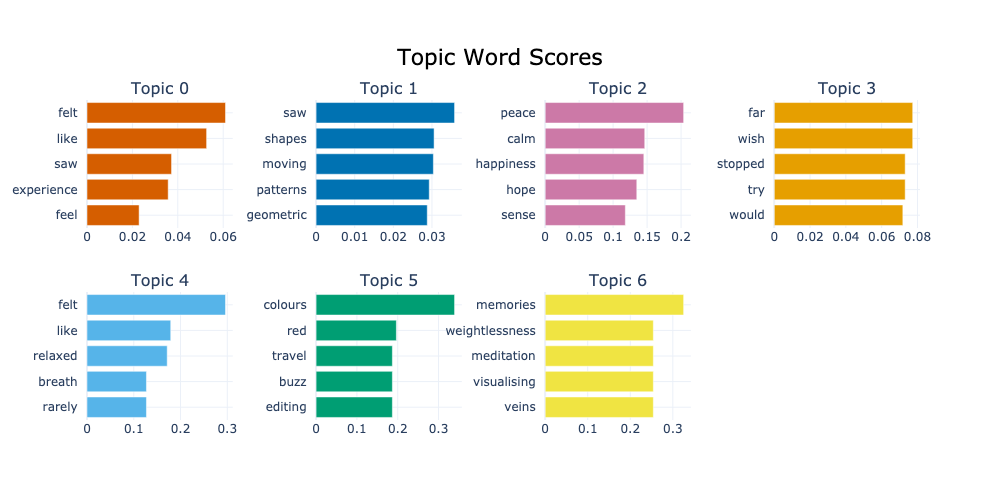

In [38]:
outputs_path = os.path.join(CODEDIR,'BERT_outputs')

# Save the barchart visualization to a file
fig = model.visualize_barchart(top_n_topics=10) #Visualize the top 10 topics
save_path_barchart = os.path.join(outputs_path,'BERT_barchart.png')
fig.write_image(save_path_barchart)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_barchart))

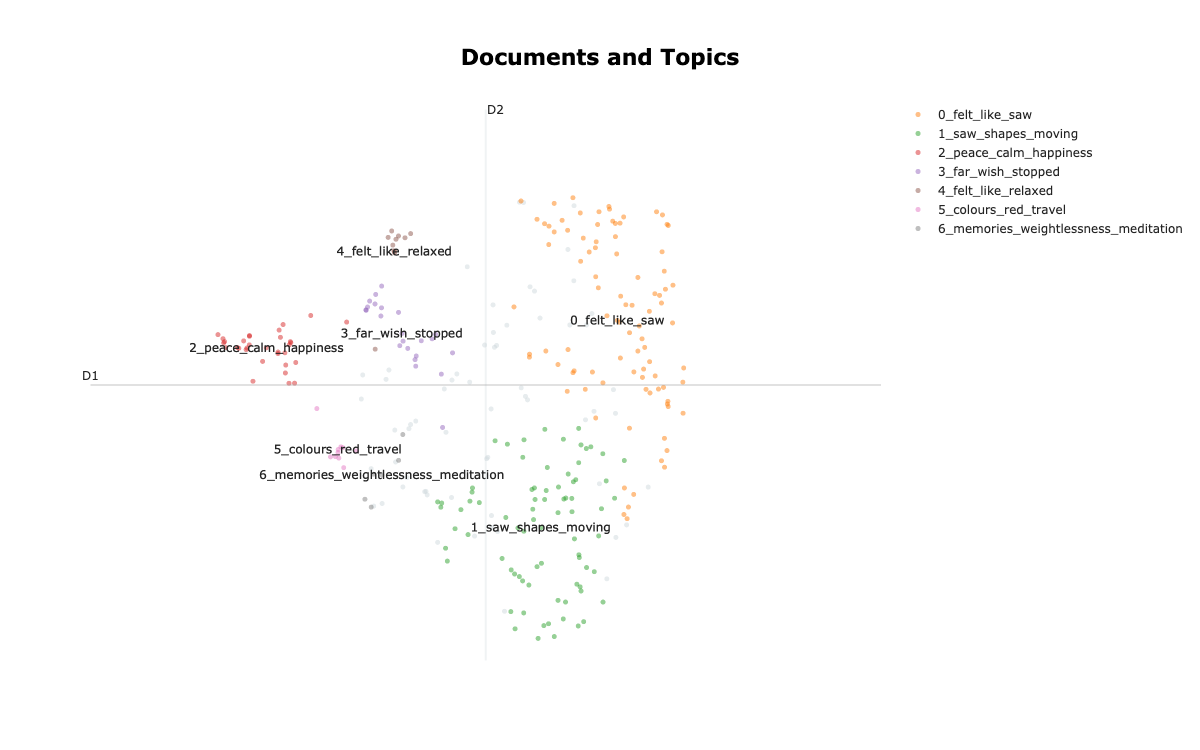

In [39]:
# Save the barchart visualization to a file
fig = model.visualize_documents(reports['reflection_answer'])
save_path_cloud = os.path.join(outputs_path,'BERT_cloud_{}.png'.format(CONDITION))
fig.write_image(save_path_cloud)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_cloud))

In [40]:
model.visualize_heatmap(top_n_topics=10) #Visualize the top 10 topics as a heatmap

In [41]:
model.visualize_term_rank()